# Driver Assist Hotspot Finder

In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

import pickle

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


Data Loading

In [4]:

df = pd.read_csv('taxi_fare.csv')
display(df.head())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,-73.782021,40.644810,1,N,-73.974541,40.675770,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,-73.863419,40.769814,1,N,-73.969650,40.757767,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,-73.971741,40.792183,3,N,-74.177170,40.695053,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80


Data Cleaning and Initial Feature Engineering

In [5]:
print(f"Shape before cleaning: {df.shape}")

# 1. Filtering out illogical data points
df = df[df['fare_amount'] > 0]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 7)]
df = df[(df['pickup_longitude'] > -75) & (df['pickup_longitude'] < -73)]
df = df[(df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42)]
df = df[(df['dropoff_longitude'] > -75) & (df['dropoff_longitude'] < -73)]
df = df[(df['dropoff_latitude'] > 40) & (df['dropoff_latitude'] < 42)]

# 2. Converting to datetime objects
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# 3. Creating Trip Duration and Trip Distance
def haversine_distance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon, dlat = lon2 - lon1, lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    return 6371 * 2 * np.arcsin(np.sqrt(a)) * 0.621371 # in miles

df['trip_distance'] = haversine_distance(df['pickup_longitude'], df['pickup_latitude'],
                                         df['dropoff_longitude'], df['dropoff_latitude'])
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# 4. Removing trips with invalid distance or duration
df = df[df['trip_distance'] > 0.1]
df = df[(df['trip_duration'] > 1) & (df['trip_duration'] < 120)]

print(f"Shape after cleaning: {df.shape}")

Shape before cleaning: (212345, 18)
Shape after cleaning: (206862, 20)


Creating the Target Variable for Classification

The threshold for a high-earning trip is $1.08 per minute.

Distribution of target classes:
is_high_earning
0    75.002175
1    24.997825
Name: proportion, dtype: float64


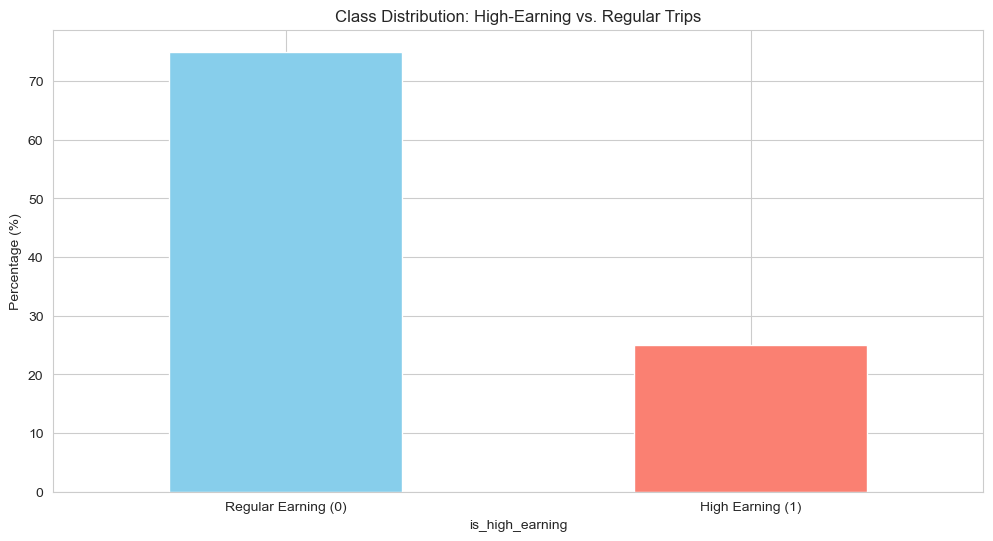

In [6]:

# 1. Engineering the 'fare_per_minute' metric to define a high-value trip
df['fare_per_minute'] = df['fare_amount'] / (df['trip_duration'] + 1e-6)

# 2. Defining the threshold for a "high-earning" trip
high_earning_threshold = df['fare_per_minute'].quantile(0.75)
print(f"The threshold for a high-earning trip is ${high_earning_threshold:.2f} per minute.")

# 3. Creating the binary target variable 'is_high_earning'
df['is_high_earning'] = (df['fare_per_minute'] > high_earning_threshold).astype(int)

# 4. Analyzing the class balance
print("\nDistribution of target classes:")
class_distribution = df['is_high_earning'].value_counts(normalize=True) * 100
print(class_distribution)

# Visualizing the distribution
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution: High-Earning vs. Regular Trips')
plt.ylabel('Percentage (%)')
plt.xticks([0, 1], ['Regular Earning (0)', 'High Earning (1)'], rotation=0)
plt.show()

Feature Selection and Data Splitting

In [7]:

# 1. Selecting features relevant to a driver's decision
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek # Monday=0, Sunday=6
df['is_weekend'] = (df['pickup_day_of_week'] >= 5).astype(int)

class_features = [
    'pickup_longitude',
    'pickup_latitude',
    'pickup_hour',
    'pickup_day_of_week',
    'is_weekend'
]

X = df[class_features]
y = df['is_high_earning']

print("Selected features for classification:")
print(X.columns.tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Selected features for classification:
['pickup_longitude', 'pickup_latitude', 'pickup_hour', 'pickup_day_of_week', 'is_weekend']

Training set shape: (155146, 5)
Testing set shape: (51716, 5)


Building and Training the Classification Model

In [8]:


# 1. Creating a preprocessing pipeline 
preprocessor = StandardScaler()
classifier_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1, class_weight='balanced', max_depth=15))
])

# 3. Train the model
print("--- Training the Driver Hotspot Classifier ---")
classifier_pipeline.fit(X_train, y_train)
print("Training complete.")

--- Training the Driver Hotspot Classifier ---
Training complete.


 Model Evaluation


--- Classification Model Performance ---
Accuracy: 0.7581
ROC AUC Score: 0.7261

Classification Report:
                 precision    recall  f1-score   support

Regular Earning       0.83      0.85      0.84     38788
   High Earning       0.52      0.48      0.50     12928

       accuracy                           0.76     51716
      macro avg       0.67      0.67      0.67     51716
   weighted avg       0.75      0.76      0.76     51716



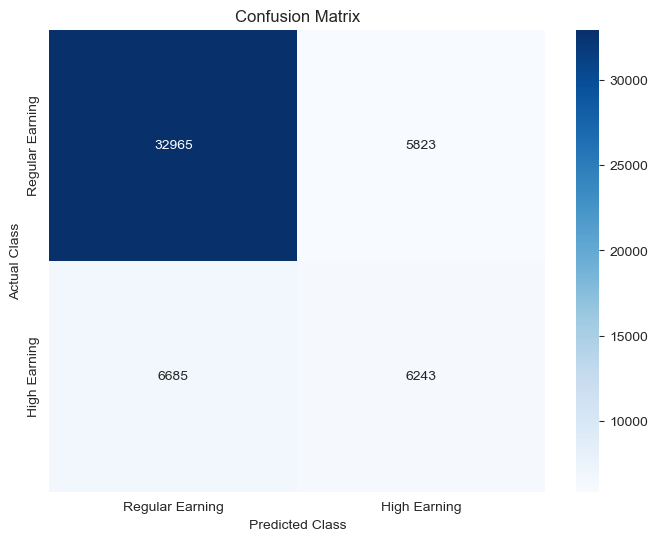

In [9]:

# 1. predictions on the test set
y_pred = classifier_pipeline.predict(X_test)
y_pred_proba = classifier_pipeline.predict_proba(X_test)[:, 1] # Probabilities for the positive class

# 2. Printinb the evaluation metrics
print("\n--- Classification Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Regular Earning', 'High Earning']))

# 3. Visualizing the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Regular Earning', 'High Earning'],
            yticklabels=['Regular Earning', 'High Earning'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

Saving the model

In [10]:

with open('driver_hotspot_classifier.pkl', 'wb') as f:
    pickle.dump(classifier_pipeline, f)

print("\n Driver hotspot classifier model has been successfully saved as 'driver_hotspot_classifier.pkl'")


 Driver hotspot classifier model has been successfully saved as 'driver_hotspot_classifier.pkl'
